In [1]:
import keras_cv as kcv
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

import keras_cv as kcv

import os
import random
import numpy as np
import math
import matplotlib.pyplot as plt


# Random seed for reproducibility
seed = 0
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [2]:
data = np.load('/kaggle/input/an2dl-homework-1-dataset/training_set_CLEANED_V2.npz')

X = data['images']
y = data['labels']

print(X.shape)
print(y.shape)

(11951, 96, 96, 3)
(11951, 1)


In [3]:
split_par = 0.2

from sklearn.model_selection import train_test_split
X_train, X_test_val, y_train, y_test_val = train_test_split(X, 
                                                            y,
                                                            random_state=seed,
                                                            test_size = split_par,
                                                            stratify=np.argmax(y,axis=1))

X_test, X_val, y_test, y_val = train_test_split(X_test_val, 
                                                y_test_val, 
                                                random_state=seed, 
                                                test_size = 0.5, 
                                                stratify=np.argmax(y_test_val,axis=1))

y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)
y_val = tfk.utils.to_categorical(y_val)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(9560, 96, 96, 3)
(1195, 96, 96, 3)
(1196, 96, 96, 3)
(9560, 8)
(1195, 8)
(1196, 8)


In [4]:
data_augmentation = kcv.layers.RandomAugmentationPipeline(
    layers=[
        kcv.layers.Solarization(threshold_factor=128.0, value_range=(0.0,255.0)),
        kcv.layers.RandomHue(factor=(0.3, 0.8),value_range=(0.0,255.0)),
        kcv.layers.Posterization(value_range=(0.0,255.0),bits=3)
    ], augmentations_per_image=2, rate=1.0, auto_vectorize=False, seed=seed
)

In [5]:
X_train = data_augmentation(X_train)

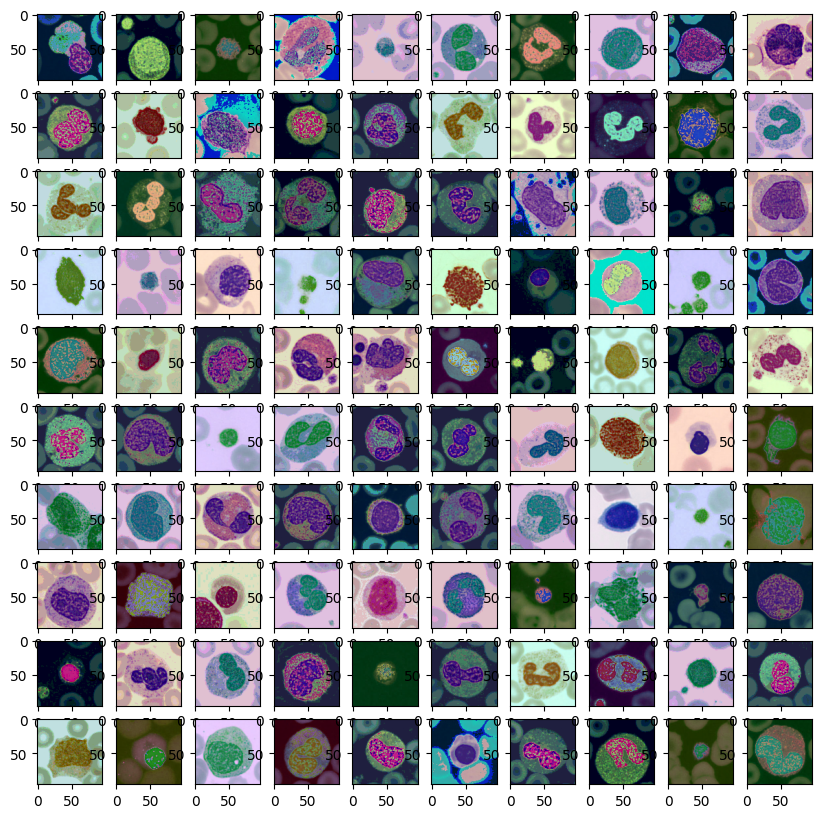

In [6]:
num = 100
fig = plt.figure(figsize=(10,10))
for i in range(1, num+1):
    fig.add_subplot(10, 10, i)
    plt.imshow(X_train[i+9000]/255)
plt.show()

In [25]:
# Initialise MobileNetV3Small model with pretrained weights, for transfer learning
mobilenet = tfk.applications.MobileNetV3Small(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

/opt/conda/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:449: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [26]:
mobilenet.trainable = False

inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')
augmentation = tf.keras.Sequential([
#tl_model.summaryhorizontal_and_vertical", seed = seed),
tfkl.RandomRotation(factor=0.5, seed = seed)
], name='preprocessing')
x = augmentation(inputs)
x = mobilenet(x)

x = tfkl.Dropout(0.3, name='dropout')(x)

outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)

tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy','F1Score'])
# Display a summary of the model architecture
#tl_model.summary(expand_nested=True)

In [27]:
# Train the model
tl_history = tl_model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = 'Model_pre.keras'
tl_model.save(model_filename)

# Free memory by deleting the model instance
del tl_model

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - F1Score: 0.1332 - accuracy: 0.1583 - loss: 2.5111 - val_F1Score: 0.2203 - val_accuracy: 0.3687 - val_loss: 1.8114
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - F1Score: 0.2122 - accuracy: 0.2671 - loss: 2.0855 - val_F1Score: 0.2955 - val_accuracy: 0.4749 - val_loss: 1.5412
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - F1Score: 0.2535 - accuracy: 0.3161 - loss: 1.8670 - val_F1Score: 0.3527 - val_accuracy: 0.5485 - val_loss: 1.3678
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - F1Score: 0.3096 - accuracy: 0.3757 - loss: 1.6961 - val_F1Score: 0.4069 - val_accuracy: 0.5895 - val_loss: 1.2498
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - F1Score: 0.3383 - accuracy: 0.4016 - loss: 1.6026 - val_F1Score: 0.4728 - val_accuracy: 0.6304 - val_loss: 1.1572
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - F1Score: 0.3770 - accuracy: 0.4379 - loss: 1.5035 - val_F1Score: 0.5109 - val_accuracy: 0.6513

In [28]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('Model_pre.keras')

In [29]:
# Set the MobileNetV3Small model layers as trainable
ft_model.get_layer('MobilenetV3small').trainable = True

# Set all MobileNetV3Small layers as non-trainable
for layer in ft_model.get_layer('MobilenetV3small').layers:
    layer.trainable = False

# Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(ft_model.get_layer('MobilenetV3small').layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True
        #print(i, layer.name, type(layer).__name__, layer.trainable)

In [30]:
# Set the number of layers to freeze
N = 124

# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model.get_layer('MobilenetV3small').layers[:N]):
    layer.trainable = False

# Print layer indices, names, and trainability status
#for i, layer in enumerate(ft_model.get_layer('MobilenetV3small').layers):
    #print(i, layer.name, layer.trainable)

In [31]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Lion(learning_rate=1e-5,weight_decay=1e-5), metrics=['accuracy','F1Score'])
#ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=tfk.metrics.F1Score())

In [32]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 100,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'Model_post.keras'
ft_model.save(model_filename)

model= ft_model

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - F1Score: 0.6606 - accuracy: 0.6744 - loss: 0.8912 - val_F1Score: 0.7997 - val_accuracy: 0.8303 - val_loss: 0.5371
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - F1Score: 0.6941 - accuracy: 0.7076 - loss: 0.7947 - val_F1Score: 0.8126 - val_accuracy: 0.8445 - val_loss: 0.5051
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - F1Score: 0.7289 - accuracy: 0.7421 - loss: 0.7140 - val_F1Score: 0.8279 - val_accuracy: 0.8570 - val_loss: 0.4562
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - F1Score: 0.7573 - accuracy: 0.7657 - loss: 0.6578 - val_F1Score: 0.8248 - val_accuracy: 0.8562 - val_loss: 0.4383
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - F1Score: 0.7652 - accuracy: 0.7774 - loss: 0.6173 - val_F1Score: 0.8357 - val_accuracy: 0.8637 - val_loss: 0.4152
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - F1Score: 0.7705 - accuracy: 0.7816 - loss: 0.5948 - val_F1Score: 0.8395 - val_accuracy: 0.867

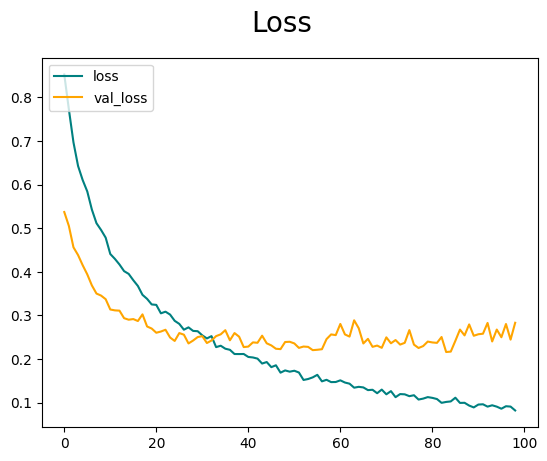

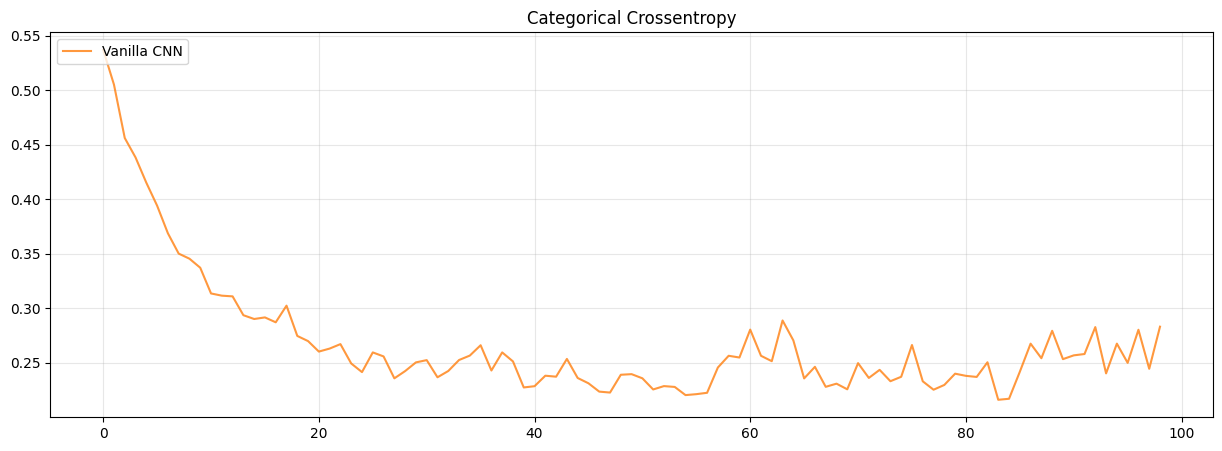

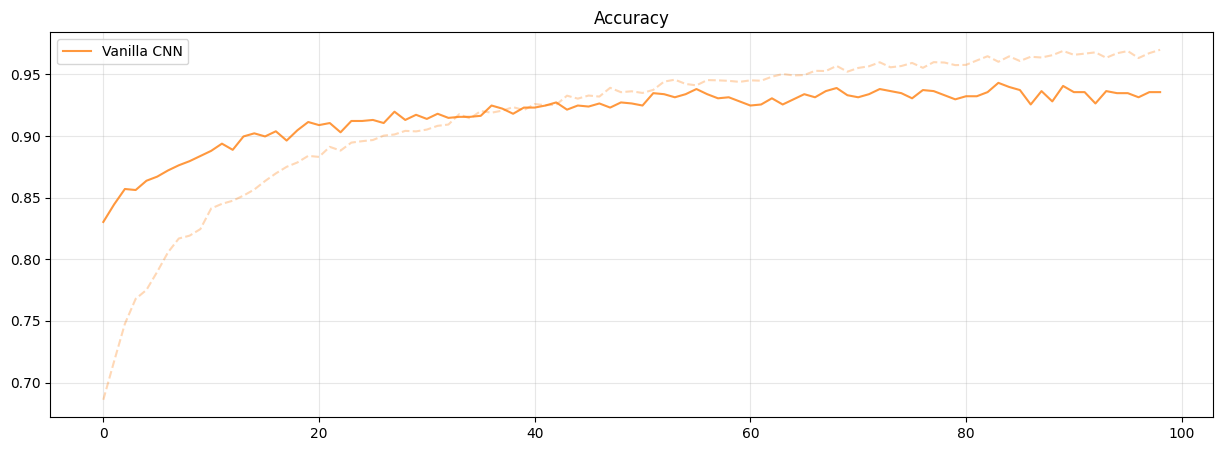

In [33]:
fig = plt.figure()
plt.plot(ft_history['loss'], color='teal', label='loss')
plt.plot(ft_history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()


# Plot the training
plt.figure(figsize=(15,5))
#plt.plot(ft_history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(ft_history['val_loss'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(ft_history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [34]:
pred = np.argmax(ft_model.predict(X_test), axis=1)

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step


Accuracy on test data: 93.39%


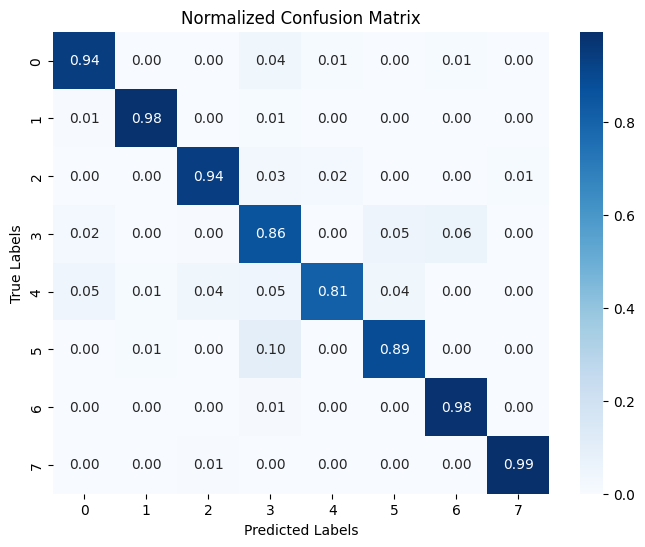

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score

true = np.argmax(y_test,axis=1)
cm = confusion_matrix(true, pred)
labels_cm = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)


'''plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=labels_cm, fmt='', xticklabels=list(range(0,7)), yticklabels=list(range(0,7)), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()'''


# Calculate accuracy
accuracy = accuracy_score(true, pred)
print(f"Accuracy on test data: {accuracy * 100:.2f}%")

#cm = confusion_matrix(true, pred)

# Normalized confusion matrix by class
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=np.arange(8), yticklabels=np.arange(8))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate and display test set accuracy
accuracy = accuracy_score(true, pred)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true, pred, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')


Accuracy score over the test set: 0.9339
Precision score over the test set: 0.9346


In [37]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('Model_post.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [38]:
from datetime import datetime
filename = f'Base_Model_2.zip'

# Add files to the zip command if needed
!zip {filename} model.py Model_post.keras

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


updating: model.py (deflated 56%)
updating: Model_post.keras (deflated 15%)
